# 1. Setup

## 1.1 Install/Import Dependencies

In [1]:
!pip list -v

Package                      Version     Location                                                                   Installer
---------------------------- ----------- -------------------------------------------------------------------------- ---------
absl-py                      2.3.1       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
anyio                        4.11.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
apt-listchanges              4.8         /usr/lib/python3/dist-packages                                             debian
argon2-cffi                  25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
argon2-cffi-bindings         25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
arrow                        1.4.0       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
asgiref                  

In [2]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from picamera2 import Picamera2

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Create Folder Structure

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)



## 2. Collect Positives and Anchors

In [6]:
#!unzip '/home/nasir/FacialRecognitionSiameseModel/lfw.zip' -d '/home/nasir/FacialRecognitionSiameseModel/lfw'

In [7]:
#Move LFW Images to the following Repository data/negative
'''for directory in os.listdir('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory)):
        EX_PATH = os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH, NEW_PATH)'''

"for directory in os.listdir('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled'):\n    for file in os.listdir(os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory)):\n        EX_PATH = os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory,file)\n        NEW_PATH = os.path.join(NEG_PATH,file)\n        os.replace(EX_PATH, NEW_PATH)"

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
uuid.uuid1()

UUID('f6c4e45c-d937-11f0-b264-2ccf67db9bc7')

In [ ]:

# Initialize the camera
picam2 = Picamera2()
    
# Create a preview configuration (640x480 is good for testing)
config = picam2.create_preview_configuration(main={"format": "XRGB8888", "size": (250, 250)})
picam2.configure(config)
    
# Start the camera
picam2.start()
    
print("Press 'q' to quit the camera feed.")
    
# Continuously capture frames and display them
while True:
    frame = picam2.capture_array()
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow("PiCamera2 Feed", frame)
    
    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
# Clean up
cv2.destroyAllWindows()
picam2.stop()





In [ ]:
frame.shape

## 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data/anchor/21412646-b83b-11f0-a223-2ccf67db9bc7.jpg'

### 3.2 Preprocessing - Scale and Resize

In [13]:
def preprocess(file_path):
    #reads in image from the file_path in byte like format
    #byte like format is any object that supports the buffer protocol
	byte_img = tf.io.read_file(file_path)
    #Load/decode the image 
	img = tf.io.decode_jpeg(byte_img)
    #resize the image to 100 by 100 by 3 array
	img = tf.image.resize(img,(100,100))
    #pixel value is between 0 and 255
    #Scaling down the pixel value down by 255 to be between 0 and 1S
	img = img / 255.0
    #returns the image
	return img

In [14]:
img = preprocess('data/anchor/0860061a-b83b-11f0-a223-2ccf67db9bc7.jpg')

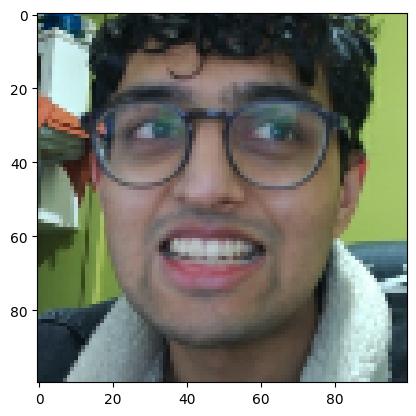

In [15]:
plt.imshow(img)

### 3.3 Create Labelled Dataset

In [16]:
#zips dataset and creates labelled dataset for positive images filled with 1 
#zipping allows us to iterate through all at same time
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#zips dataset and creates labelled dataset for negative images filled with 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#joining positives and negatives together to create one dataset
data = positives.concatenate(negatives)

In [17]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example=samples.next()
example

(b'data/anchor/1f2661c8-b83b-11f0-a223-2ccf67db9bc7.jpg',
 b'data/positive/19adc1b4-b83b-11f0-a223-2ccf67db9bc7.jpg',
 np.float32(1.0))

#### 3.3.1 Build Train and Test Partition 

In [20]:
#passes the input and validation image through preprocessing 
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [21]:
res = preprocess_twin(*example)

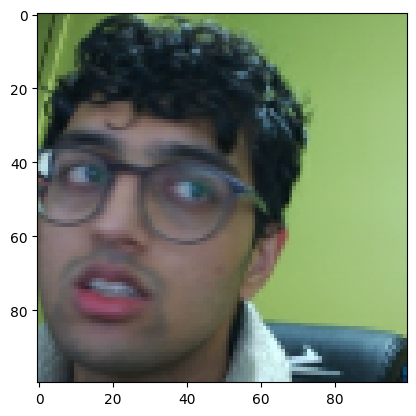

In [22]:
plt.imshow(res[1])

In [23]:
#Build dataloader pipeline
data = data.map(preprocess_twin)#applies preprocess_twin function to every item in data
data = data.cache()#Caching stores the results, so they only need to run once
data = data.shuffle(buffer_size=1024)#Randomizes the order of elements in the dataset

In [24]:
samples = data.as_numpy_iterator()

In [25]:
sample = samples.next()

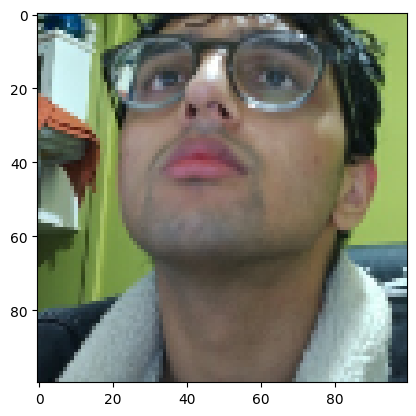

In [26]:
plt.imshow(sample[0])#anchor image

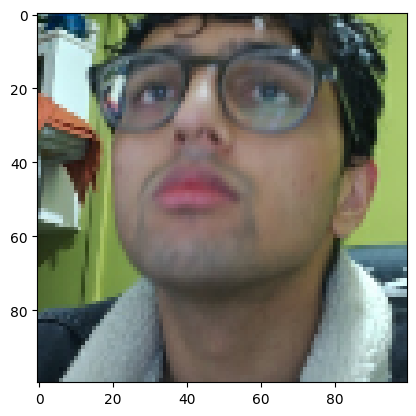

In [27]:
plt.imshow(sample[1])#positive/negative image

In [28]:
sample[2]#label 1=positive, 0=negative

np.float32(1.0)

In [29]:
round(len(data))

600

In [30]:
#Training partition
train_data = data.take(round(len(data)*0.7))#takes the data and splits it for training data
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
#Testing partition
test_data = data.skip(round(len(data)*0.7))#skips the training data 
test_data = test_data.take(round(len(data)*0.3))

## 4.0 Build Model

### 4.1 Embedding Layer

In [32]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')#input layer
    
    c1 = Conv2D(64,(10,10), activation='relu')(inp)#64 filters @ 10x10 pixels
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)#64 filters and shape is 2x2
    
    c2 = Conv2D(128,(7,7), activation='relu')(m1)#128 filters @ 7x7 pixels
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)#64 filters and shape is 2x2
    
    c3 = Conv2D(128,(4, 4), activation='relu')(m2)#128 filters @ 4x4 pixels
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)#64 filters and shape is 2x2

    c4 = Conv2D(256,(4, 4), activation='relu')(m3)#256 filters @ 4x4 pixels
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)#4096 vectors
    
    return Model(inputs=inp, outputs=d1, name='embedding')#returns embedding 

In [33]:
embeddingLayer = make_embedding()

In [34]:
embeddingLayer.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Distance Layer

In [35]:
class L1Dist(Layer):#passes base Layer class
    def __init__(self, **kwargs):#basic init method
        super().__init__()
        
    #standard Keras Siamese distance layer
    def call(self, input_embedding, validation_embedding):#input = anchor, validation = pos/neg img
        return tf.math.abs(input_embedding - validation_embedding)#similarity calculation

### 4.3 Siamese Model

In [36]:
def make_siamese_model(): 
    
    # Anchor image 
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combines siamese distance layer components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embeddingLayer(input_image), embeddingLayer(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork') # return siamese model

In [37]:
siamese_model = make_siamese_model()

In [38]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [39]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [40]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [41]:
checkpoint_dir = '/home/nasir/FacialRecognitionSiameseModel/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## 5.3 Train Step Function

In [42]:
@tf.function #complies function into a callable tensorflow graph
def train_step(batch):
    with tf.GradientTape() as tape:#Records operations for automatic differentiation
        # Get anchor and positve/negative image
        X = batch[:2] #16 img per batch
        #get label
        y = batch[2]

        #Forward pass
        yhat = siamese_model(X, training=True)#perdiction
        #Calculate loss
        loss = binary_cross_loss(y, yhat)

    #Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables) 

    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## 5.4 Build Training Loop

In [43]:
def train(data, EPOCHS):
    # Loop through the epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
    
        #Loop through each batch
        for idx, batch in enumerate(train_data):
            #Run training
            train_step(batch)
            progbar.update(idx+1)
    
        #Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 50

## 5.5 Train the model

In [ ]:
train(train_data,EPOCHS)

# 6. Evaluate Model

In [49]:
checkpoint_dir = '/home/nasir/FacialRecognitionSiameseModel/training_checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(f'Loading checkpoint: {latest_checkpoint}')

Loading checkpoint: /home/nasir/FacialRecognitionSiameseModel/training_checkpoints/ckpt-5


In [50]:
# Restore the checkpoint
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
checkpoint.restore(latest_checkpoint)
print('Model loaded successfully!')

Model loaded successfully!


In [51]:
# Verify model is loaded
print(f'Model has {len(siamese_model.trainable_variables)} trainable variables')

Model has 12 trainable variables


## 6.2 Prepare Test Data

In [52]:
## 6.2 Prepare Test Data
# dataset
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

# Create labeled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# Preprocess
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Split into train and test
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

print(f'Test data prepared with {len(test_data)} batches')

Test data prepared with 12 batches


In [53]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [54]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [55]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [56]:
# Post processing predictions
predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [57]:
#Calculate Metrics
precision = Precision()
recall = Recall()

In [58]:
precision.update_state(y_true, y_hat)
recall.update_state(y_true, y_hat)

In [59]:
print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')

Precision: 1.0
Recall: 0.875


## 6.3 creating sublpots for visualisation

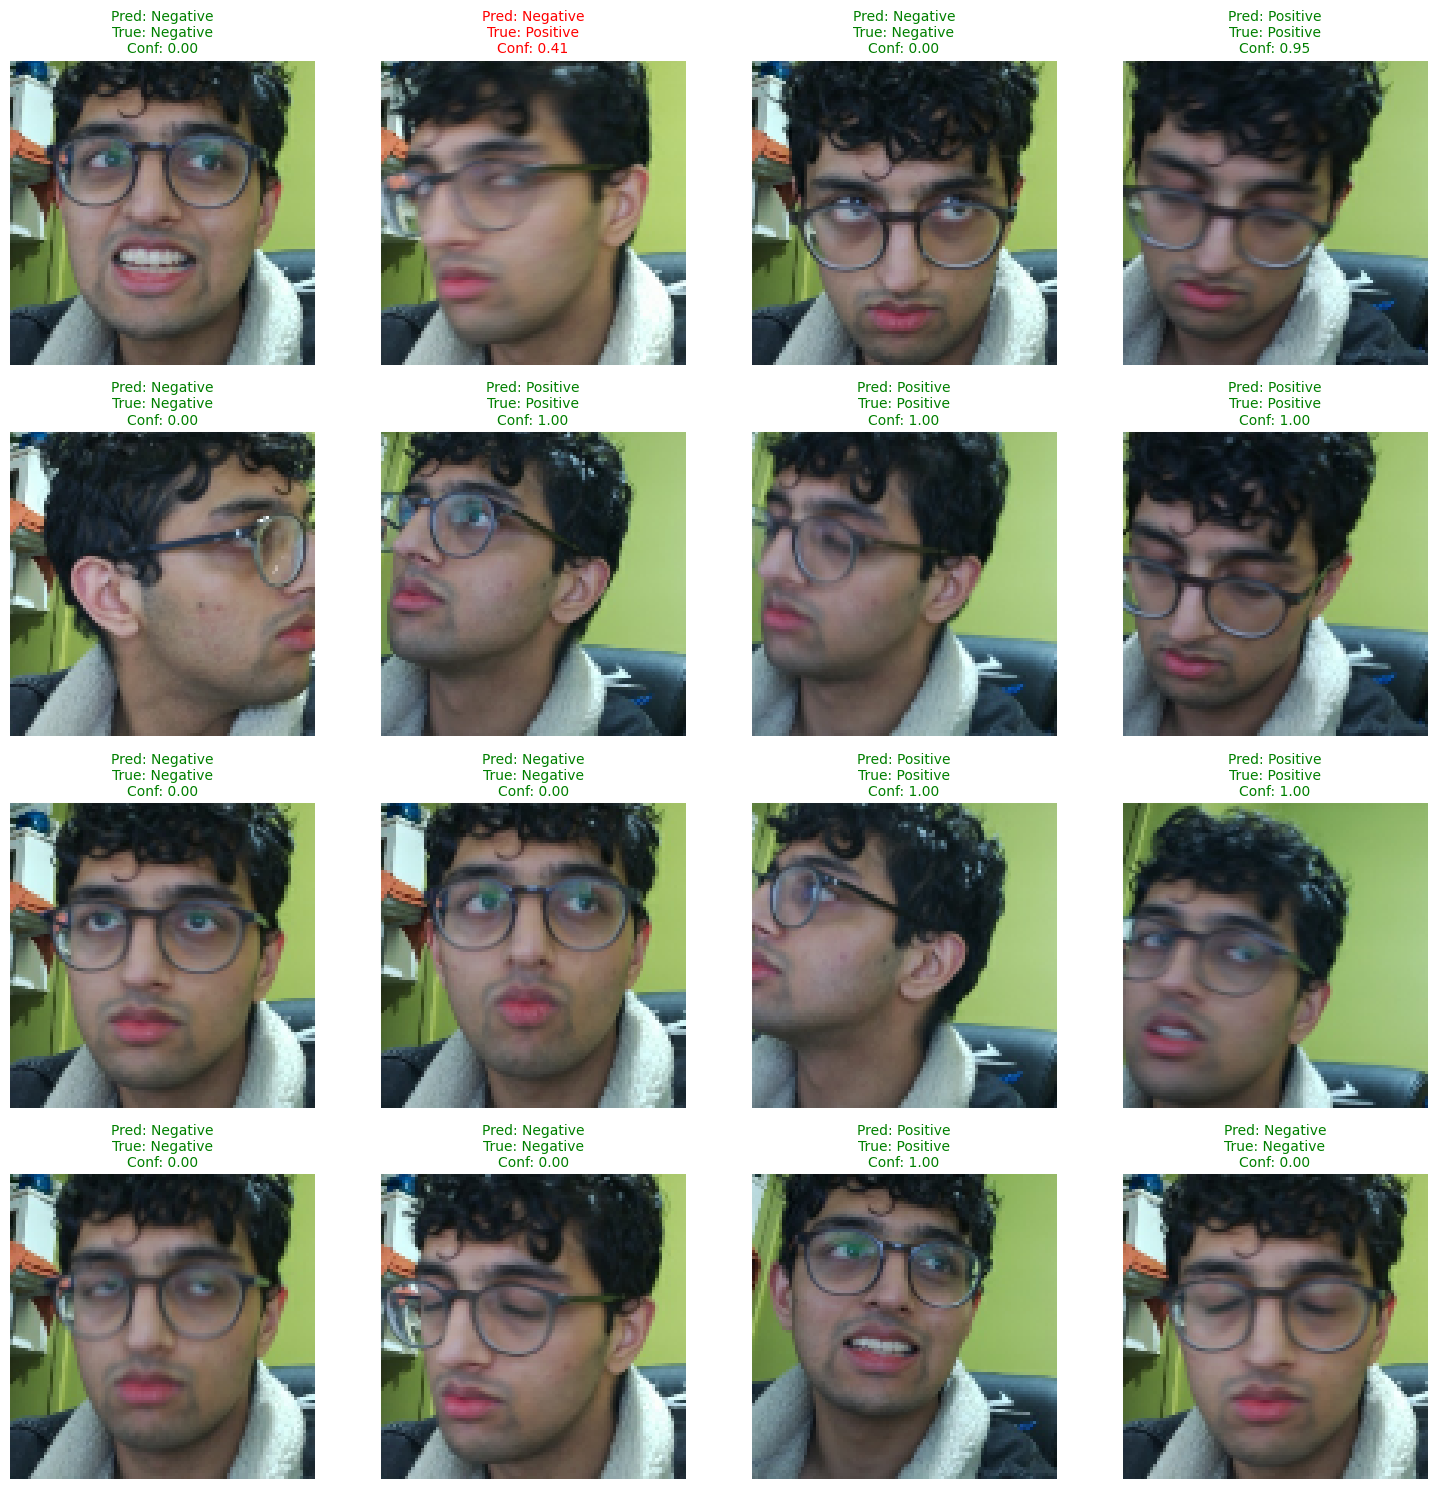

In [60]:
# Create subplots to visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i in range(16):
    ax = axes[i // 4, i % 4]
    
    # Plot anchor image
    ax.imshow(test_input[i])
    
    # Add prediction and ground truth as title
    pred_label = 'Positive' if predictions[i] != 0 else 'Negative'
    true_label = 'Positive' if y_true[i] != 0 else 'Negative'
    color = 'green' if predictions[i] == y_true[i] else 'red'
    
    ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}\nConf: {y_hat[i][0]:.2f}', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

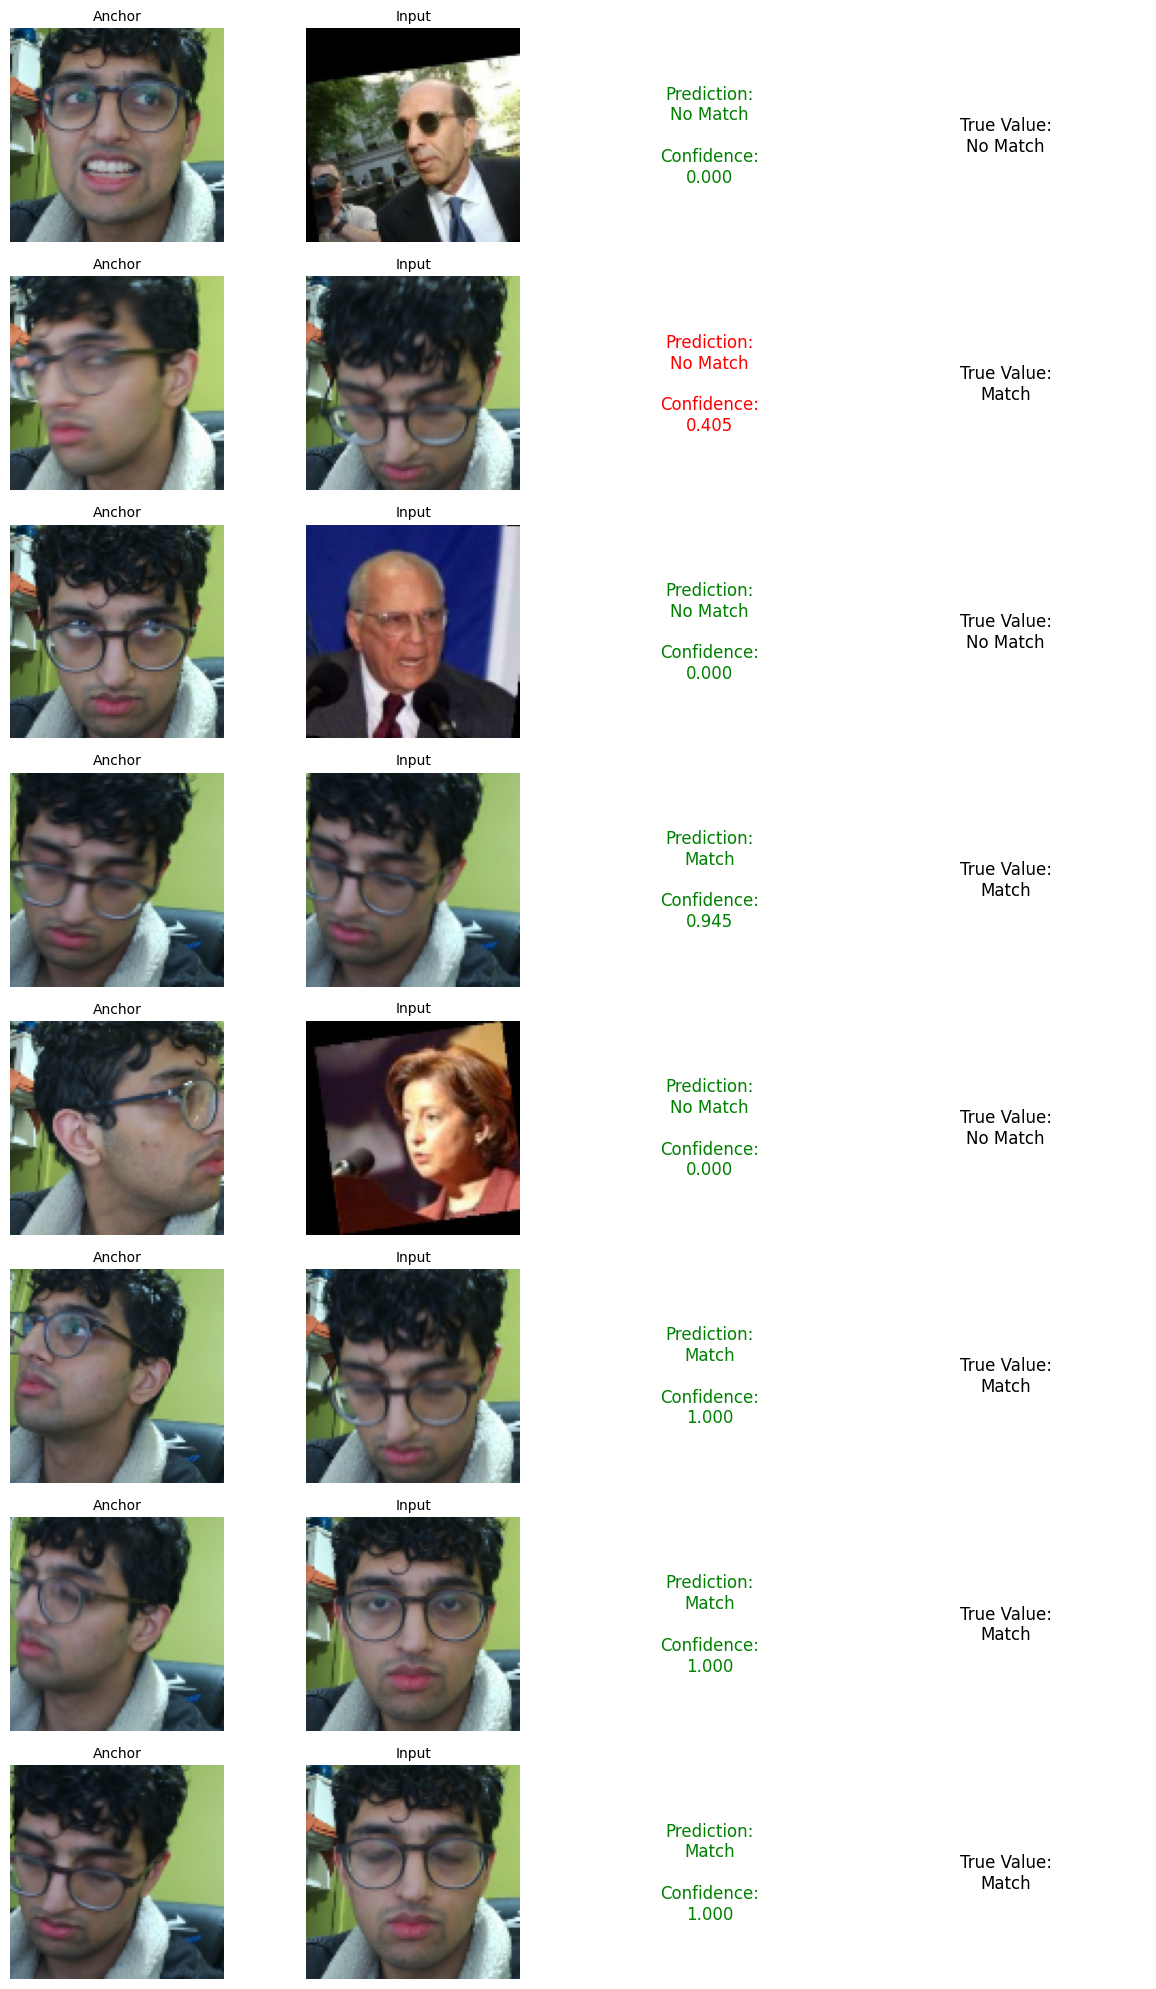

In [61]:
fig, axes = plt.subplots(8, 4, figsize=(12, 20))

for i in range(8):
    # Anchor image
    axes[i, 0].imshow(test_input[i])
    axes[i, 0].set_title('Anchor', fontsize=10)
    axes[i, 0].axis('off')
    
    # Validation image
    axes[i, 1].imshow(test_val[i])
    axes[i, 1].set_title('Input', fontsize=10)
    axes[i, 1].axis('off')
    
    # Prediction
    pred_label = 'Match' if predictions[i] == 1 else 'No Match'
    true_label = 'Match' if y_true[i] == 1 else 'No Match'
    color = 'green' if predictions[i] == y_true[i] else 'red'
    
    axes[i, 2].text(0.5, 0.5, f'Prediction:\n{pred_label}\n\nConfidence:\n{y_hat[i][0]:.3f}',
                    ha='center', va='center', fontsize=12, color=color)
    axes[i, 2].axis('off')
    
    axes[i, 3].text(0.5, 0.5, f'True Value:\n{true_label}',
                    ha='center', va='center', fontsize=12)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [62]:
siamese_model.save('siamesemodelv2.h5')

In [63]:
model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [64]:
y_hat_loaded = model.predict([test_input, test_val])
print(f'\nLoaded model prediction sample: {y_hat_loaded[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Loaded model prediction sample: [5.5452288e-12]


# verification

In [ ]:

# Initialize the camera
picam2 = Picamera2()
    
# Create a preview configuration (640x480 is good for testing)
config = picam2.create_preview_configuration(main={"format": "XRGB8888", "size": (250, 250)})
picam2.configure(config)
    
# Start the camera
picam2.start()
    
print("Press 'q' to quit the camera feed.")
    
# Continuously capture frames and display them
while True:
    frame = picam2.capture_array()
    #Collect verification images
    if cv2.waitKey(1) & 0XFF == ord('i'):
        # Create the unique file path 
        imgname = os.path.join('application_data/verification_images', '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow("PiCamera2 Feed", frame)
    
    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
# Clean up
cv2.destroyAllWindows()
picam2.stop()

[2:12:46.047045964] [9184]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[2:12:46.056476659] [9233]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[2:12:46.142337435] [9233]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx708.json
[2:12:46.152129223] [9233]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a' for pipeline handler rpi/pisp
[2:12:46.152169889] [9233]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_D0
[2:12:46.162045326] [9184]  INFO Camera camera.cpp:1215 configuring streams: (0) 250x250-XRGB8888/sRGB (1) 1536x864-BGGR_PISP_COMP1/RAW
[2:12:46.162269752] [9233]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10/RAW - Selected CFE format: 1536x864-PC1B/RAW


Press 'q' to quit the camera feed.


[2:12:47.338481766] [9233]  WARN V4L2 v4l2_videodevice.cpp:2155 /dev/video4[85:cap]: Dequeue timer of 1000000.00us has expired!
[2:12:47.338516507] [9233] ERROR RPI pipeline_base.cpp:1346 Camera frontend has timed out!
[2:12:47.338520748] [9233] ERROR RPI pipeline_base.cpp:1347 Please check that your camera sensor connector is attached securely.
[2:12:47.338523637] [9233] ERROR RPI pipeline_base.cpp:1348 Alternatively, try another cable and/or sensor.


In [55]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    
    # Get input image from verification folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Compare with images in input folder
        for val_image in os.listdir(os.path.join('application_data', 'input_image')):
            validation_img = preprocess(os.path.join('application_data', 'input_image', val_image))
            
            # Make predictions
            result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
            results.append(result)
    
    # Detection threshold: metric above which prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification threshold: proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
## 9.3 OpenCV Real-Time Verification with PiCamera2
# Check if verification images are ready
verification_count = len(os.listdir('application_data/verification_images'))
print(f"\nVerification images available: {verification_count}")

if verification_count == 0:
    print("WARNING: No verification images found!")
    print("Please run collect_verification_images() first or manually add images")
    print("to 'application_data/verification_images/'")
else:
    print(f"Ready to verify! Press 'v' to verify against {verification_count} reference images")

# Initialize camera
picam2 = Picamera2()
config = picam2.create_preview_configuration(main={"format": "XRGB8888", "size": (250, 250)})
picam2.configure(config)
picam2.start()

print("\nControls:")
print("  'v' - Verify current frame")
print("  'q' - Quit")

verification_result = None
verification_score = None

while True:
    frame = picam2.capture_array()
    
    # Display verification result on frame
    if verification_result is not None:
        status_text = "VERIFIED" if verification_result else "NOT VERIFIED"
        color = (0, 255, 0) if verification_result else (0, 0, 255)
        cv2.putText(frame, status_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        if verification_score is not None:
            cv2.putText(frame, f'Score: {verification_score:.1%}', (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        if verification_count > 0:
            # Save input image
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            
            # Run verification
            print("\nVerifying...")
            results, verified = verify(siamese_model, 0.5, 0.5)
            
            if len(results) > 0:
                detection_count = np.sum(np.array(results) > 0.5)
                verification_score = detection_count / verification_count
                verification_result = verified
                
                print(f'Verified: {verified}')
                print(f'Detection Score: {detection_count} / {verification_count} ({verification_score:.1%})')
                print(f'Confidence scores: {[f"{r[0][0]:.3f}" for r in results[:5]]}...')
            else:
                print("Verification failed - no results")
        else:
            print("No verification images available!")
        
    cv2.imshow('Verification', frame)
    
    # Exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
picam2.stop()


Verification images available: 10
Ready to verify! Press 'v' to verify against 10 reference images

Controls:
  'v' - Verify current frame
  'q' - Quit


[1:41:24.638962805] [6708]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[1:41:24.658491634] [7046]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[1:41:24.739366710] [7046]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx708.json
[1:41:24.746925548] [7046]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a' for pipeline handler rpi/pisp
[1:41:24.746941733] [7046]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_D0
[1:41:24.750932829] [6708]  INFO Camera camera.cpp:1215 configuring streams: (0) 250x250-XRGB8888/sRGB (1) 1536x864-BGGR_PISP_COMP1/RAW
[1:41:24.751032773] [7046]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10/RAW - Selected CFE format: 1536x864-PC1B/RAW



Verifying...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Verified: True
Detection Score: 7 / 10 (70.0%)
Confidence scores: ['0.734', '0.000', '1.000', '1.000', '0.994']...

Verifying...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Verified: False
Detection Score: 5 / 10 (50.0%)
Confidence scores: ['0.384', 

[1:43:03.806732322] [7046]  WARN V4L2 v4l2_videodevice.cpp:2155 /dev/video4[93:cap]: Dequeue timer of 1000000.00us has expired!
[1:43:03.806813619] [7046] ERROR RPI pipeline_base.cpp:1346 Camera frontend has timed out!
[1:43:03.806820860] [7046] ERROR RPI pipeline_base.cpp:1347 Please check that your camera sensor connector is attached securely.
[1:43:03.806824934] [7046] ERROR RPI pipeline_base.cpp:1348 Alternatively, try another cable and/or sensor.


In [ ]:
print("\nTesting verification system...")
results, verified = verify(siamese_model, detection_threshold=0.5, verification_threshold=0.5)
print(f'Results: {results}')
print(f'Verified: {verified}')
print(f'Verification Score: {np.sum(np.array(results) > 0.5) / len(results):.2%}')